This data comes from the Surveillance Atlas of Infections Diseases (European Centre for Disease Prevenction and Control - ECDC) and covers the 2005-2021 time interval for all countries in the European Economic Area (EEA), meaning all countries in the European Union (EU) plus Iceland, Liechtenstein, and Norway. 

<i>(I) Data pre-processing</i>

In [2]:
# Importing the relevant libraries
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor
import warnings
# It is expected that the same Gaussian parameters will not fit all the countries well. Warnings are ignored to avoid seeing many messages saying the same thing
warnings.filterwarnings('ignore')

In [3]:
# Defining the paths
acinetobacter = r"C:/Users/franc/resistance_capstone/Antibiotics/Acinetobacter"
escherichia_coli = r"C:/Users/franc/resistance_capstone/Antibiotics/Escherichia_coli"
klebsiella_pneumoniae= r"C:/Users/franc/resistance_capstone/Antibiotics/Klebsiella_pneumoniae"

# List of paths
paths = [acinetobacter, escherichia_coli, klebsiella_pneumoniae]


In [4]:
# Getting the list of files on each folder
for folder in paths:
    file_list= os.listdir(folder)
    print(f'Files in {os.path.basename(folder)}: {file_list}')


Files in Acinetobacter: ['totalisolated_2005_2021_amynoglycosides.csv', 'totalisolated_2005_2021_carbapenems.csv', 'totalisolated_2005_2021_combinedresistance.csv', 'totalisolated_2005_2021_fluoroquinolones.csv']
Files in Escherichia_coli: ['totalisolated_2005_2021_3rdgencephalosporin.csv', 'totalisolated_2005_2021_aminoglycosides.csv', 'totalisolated_2005_2021_carbapanems.csv', 'totalisolated_2005_2021_combinedresistance.csv', 'totalisolated_2005_2021_fluoroquinolones.csv']
Files in Klebsiella_pneumoniae: ['totalisolated_2005_2021_3rdgencephalosporins.csv', 'totalisolated_2005_2021_aminoglycosides.csv', 'totalisolated_2005_2021_carbapennems.csv', 'totalisolated_2005_2021_combinedresistance.csv', 'totalisolated_2005_2021_fluoroquinolones.csv']


In [5]:
# Append all data regarding each microorganism in one single csv
for folder in paths:
    file_list= os.listdir(folder)
    for file in file_list:
        # Combine all csv files
        combined_csv = pd.concat([pd.read_csv(os.path.join(folder, file)) for file in file_list])
        # Exporting new csv
        combined_csv.to_csv( f"combined_{os.path.basename(folder)}.csv", index=False, encoding='utf-8-sig')

In [6]:
# Getting the list of combined csv files
all_combined_csv = glob.glob('*.{}'.format('csv'))

def data_clean(file_name, string_to_remove):
    """"
    This function removes unnecessary columns and values from a specific csv file
    
    Input:
    file_name (str): The name of the file that the function will interact with
    string_to_remove (str): The redundant string to be removed from the Population column

    Output:
    df (Dataframe): The "treated" dataframe
    """
    # Load as df
    df = pd.read_csv(file_name)
    # Drop unnecessary columns: Unit is always "N", TxtValue is empty, RegionCode is redundant, and HealthTopic is always "Antimicrobial resistance"
    df = df.drop(columns=['Unit', 'TxtValue', 'HealthTopic', 'RegionCode'])
    # For the sake of keeping it relevant to the context of in development countries, this research will not include a country if HDI ≥ 9.0
    df = df[df.RegionName.isin(['Belgium','Norway', 'Iceland', 'Switzerland', 'Ireland', 'Germany', 'Denmark', 'Austria', 'Netherlands', 'Sweden', 'Finland', 'United Kingdom']) == False]
    # Remove the redundant name of pathogen
    df['Population'] = df['Population'].str.replace(string_to_remove, '', regex= True)
    # Rename column Population to resistant_to
    df.rename(columns = {'Population':'resistant_to'}, inplace = True)
    # Set the NumValue column to real num values for further plotting purposes
    df['NumValue'] = df['NumValue'].str.replace('-', '0', regex= True)
    df['NumValue'] = df['NumValue'].astype(float)
    return df

# All strings that must be removed
strings_to_remove= ['Acinetobacter spp.\|', 'Escherichia coli\|', 'Klebsiella pneumoniae\|', 'Pseudomonas aeruginosa\|'] 

# Defining each scaled_df df
for index, item in enumerate(all_combined_csv):
    # Removing .csv to name the df
    globals()[f'df_{os.path.basename(item)[:-4]}']= data_clean(item, strings_to_remove[index])


It is important to understand the jargon present in the data. Basically, there are three possible values for indicators: R - resistant isolates, I - susceptible, increased exposure, and S - susceptible isolates.
[The European Commitee on Antimicrobial Susceptibility Testing (EUCAST-2019)](https://www.eucast.org/newsiandr#:~:text=I%20%2D%20Susceptible%2C%20increased%20exposure*%3A,at%20the%20site%20of%20infection.) defines each one of those as the following: <br>
<ul>
<li>R - resistant isolates: even with increased exposure to the antimicrobial, it is very likely the pathogens will not disappear. </li>
<li>I- susceptible, increased exposure: there is a high chance of therapeutic success once the pathogen is exposed to higher concentrations of the antimicrobial.</li>
<li>S - susceptible isolates: pathogen is suscetible to disappear with standard doses of the antimicrobial </li>


</ul>

In [7]:
# Get unique countries and unique antimicrobials
list_of_countries= df_combined_Klebsiella_pneumoniae.RegionName.unique()
list_of_antimicrobials_t= df_combined_Klebsiella_pneumoniae.resistant_to.unique()
# Third_generation_cephalosporins & combined resistance seem to have some inconsistencies/ data lack and thus will not be included 
list_of_antimicrobials_t= np.delete(list_of_antimicrobials_t, [0,3])
# Emptylist that will be filled after removing the spaces/dashes between the words
list_of_antimicrobials = []
# Remove spaces, dashes, parenthesis from existing names
for i in list_of_antimicrobials_t:
    j = i.replace(' ','_').replace('-','_')
    list_of_antimicrobials.append(j)
# For Acinetobacter spp.
temp_resistant_Klebsiella_pneumoniae = df_combined_Klebsiella_pneumoniae[df_combined_Klebsiella_pneumoniae['Indicator'] == 'R - resistant isolates']
# This list will store titles based on df names
df_strs = []
# This lis will store the dfs
df_names = []
# Save temporary filtered df
for country in list_of_countries:
    for medicine in list_of_antimicrobials:
        # Store each df
        df_temp= globals()[f'df_{country}_Klebsiella_pneumoniae_{medicine}']= temp_resistant_Klebsiella_pneumoniae[(temp_resistant_Klebsiella_pneumoniae['RegionName']==f'{country}') & (temp_resistant_Klebsiella_pneumoniae['resistant_to'] == f'{medicine}')]
        # Store the titles based on the iteration of the country
        df_strs.append(f'{medicine}-resistant Klebsiella Pneumoniae found in {country}')
        # Add to the list of dfs
        df_names.append(df_temp)
        rolling_mean = df_temp['NumValue'].rolling(window = 2).mean()
        plt.figure(figsize=(15, 10))
        plt.plot(df_temp['Time'],df_temp['NumValue'], color= 'blue', label = 'Original')
        plt.plot(df_temp['Time'], rolling_mean,  color = 'red', label = 'Rolling Mean')
        plt.title (f'Resistance Klebsiella_pneumoniae to {medicine} in {country} (2005-2021) & rolling mean trend', fontsize= 20)
        plt.xlabel('Time (Year)', fontsize= 12)
        plt.ylabel('Resistant pathogens found (Number)', fontsize= 12)
        plt.legend(loc = 'best')
        plt.savefig(f'C:/Users/franc/resistance_capstone/Antibiotics/plots_Country_pathogen/{country}_{medicine}.jpg')
        plt.close()




<i>(II) Linear Models Experimentation</i>

<i>(a) Gaussian Process Regression </i>

In [8]:
for count in range(len((df_names))):
    # Define X
    y = np.array(df_names[count]['NumValue'])
    # Define X
    X = np.array(df_names[count]['Time']).reshape(-1,1)
    # 15 years of training and 2 of prediction
    X_train= np.array(df_names[count]['Time'][:15:]).reshape(-1,1)
    X_test = np.array(df_names[count]['Time'][::]).reshape(-1,1)
    y_train= np.array(df_names[count]['NumValue'][:15:])
    y_true = np.array(df_names[count]['NumValue'][::])

    # RBF kernel is set with large lenght-scale parameter to capture long trend
    long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
    # Small irregularities are accounted for in the Rational Quadratic Kernel
    irregularity_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
    # Noise in the dataset is accounted for in the with the addition of white noise
    noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
        noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
    )
    # Resulting Kernel
    resistance_kernel = noise_kernel + long_term_trend_kernel + irregularity_kernel
    # Fit Gaussian Process
    gaussian_process = GaussianProcessRegressor(kernel=resistance_kernel, normalize_y=True)
    gaussian_process.fit(X_train, y_train)
    # Create the predictions with calculations for the std and mean as well
    mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
    # Plot the predictions and data
    plt.figure(figsize=(15, 10))
    plt.plot(X, y, color="black", label="Measurements")
    plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process", linestyle="dashed")
    plt.fill_between(
        X_test.ravel(),
        mean_y_pred - std_y_pred,
        mean_y_pred + std_y_pred,
        color="tab:blue",
        alpha=0.2,
        label= '95% confidence interval'
    )
    plt.axvline(x = 2019, color = 'red', label = 'Prediction starts', alpha=0.2, linestyle="dashed")
    plt.xlabel("Year")
    plt.ylabel("Number of resistant pathogens found")
    save = str(np.array(df_names[count]['RegionName'][:1:]))
    _ = plt.title(df_strs[count])
    plt.legend(loc = 'best')
    plt.savefig(f'C:/Users/franc/resistance_capstone/Antibiotics/plots_gaussian_general/gaussian_{save}_{count}.jpg')
    plt.close()
    # print(f'{mean_squared_error(y_true, mean_y_pred)}')




We will focus on tunning Italy, the worst performing country in terms of HAI control

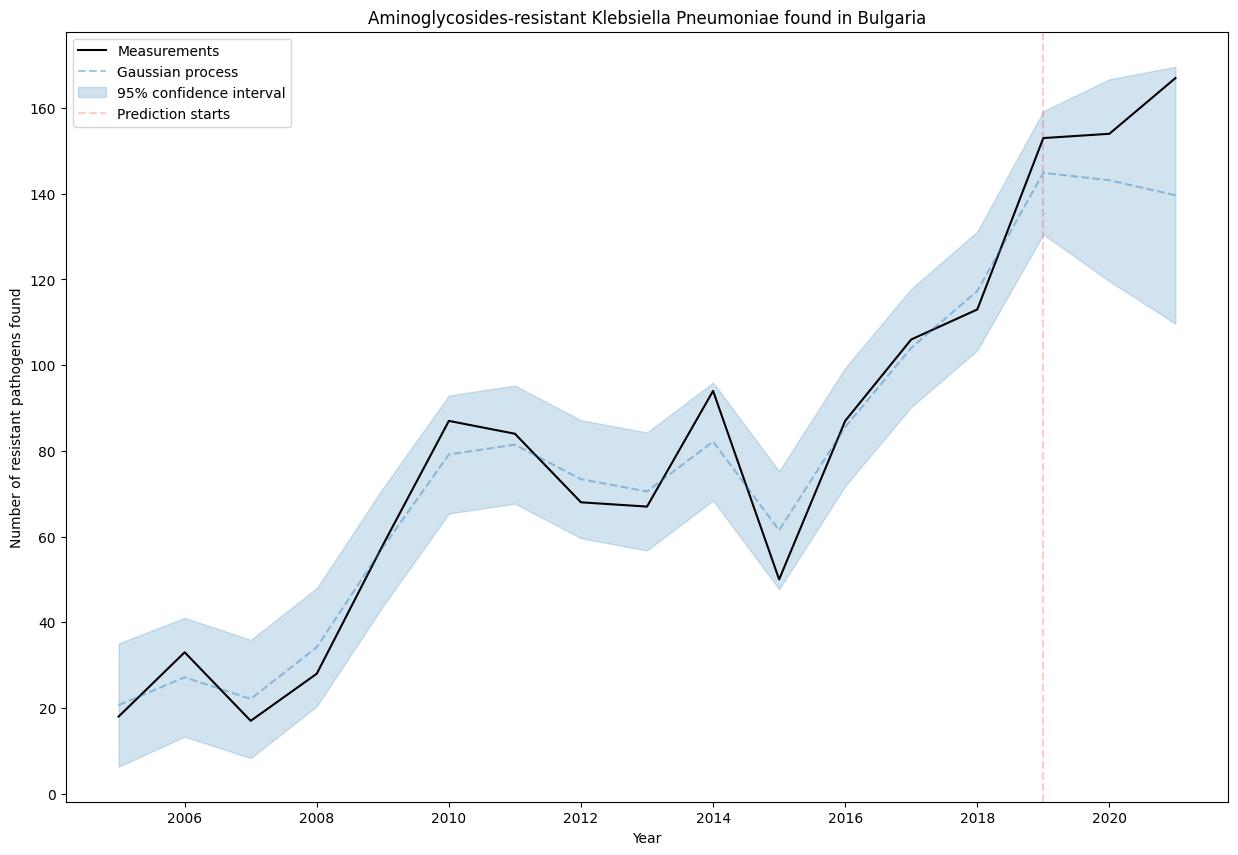

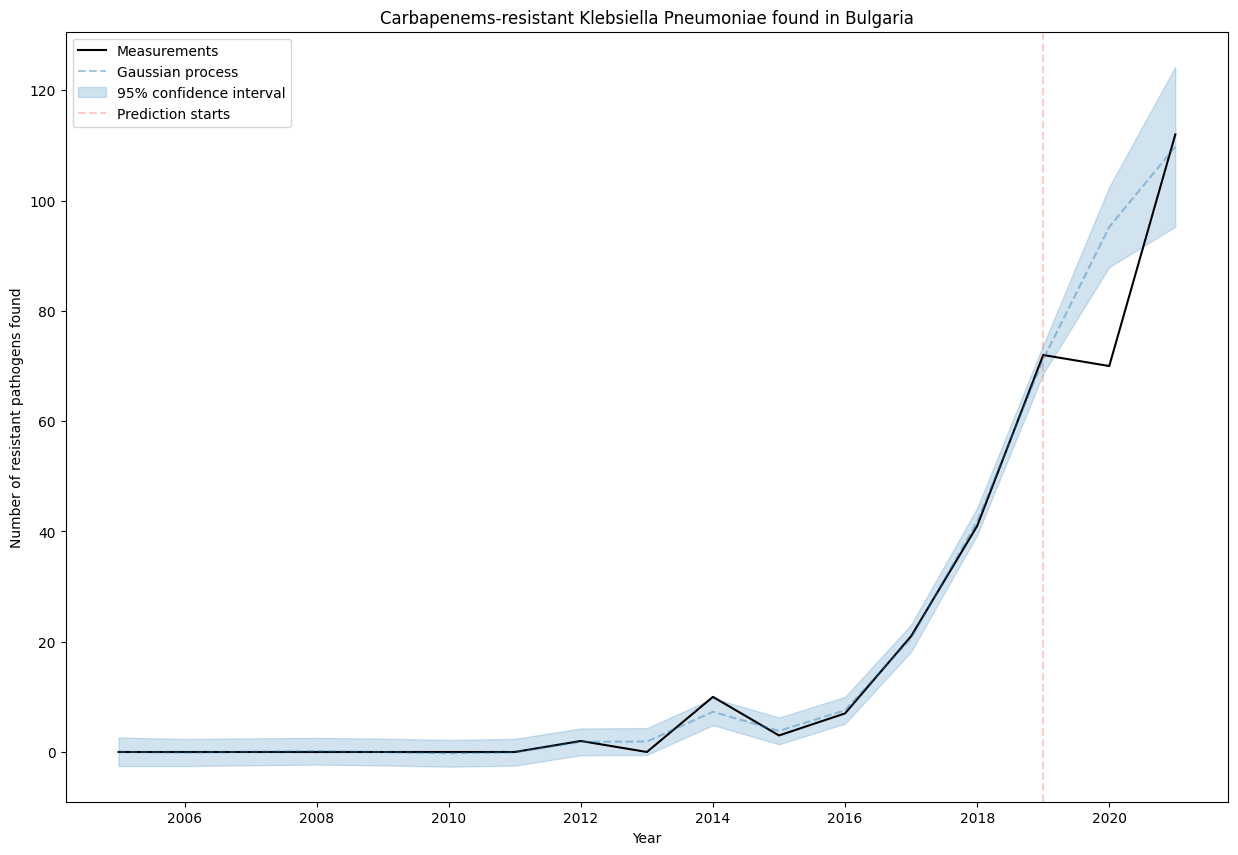

In [55]:
# Italy
for count in range(0,2):
    # Define X
    y = np.array(df_names[count]['NumValue'])
    # Define X
    X = np.array(df_names[count]['Time']).reshape(-1,1)
    # 15 years of training and 2 of prediction
    X_train= np.array(df_names[count]['Time'][:15:]).reshape(-1,1)
    X_test = np.array(df_names[count]['Time'][::]).reshape(-1,1)
    y_train= np.array(df_names[count]['NumValue'][:15:])
    y_true = np.array(df_names[count]['NumValue'][::])

    # RBF kernel is set with large lenght-scale parameter to capture long trend
    long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
    # Small irregularities are accounted for in the Rational Quadratic Kernel
    irregularity_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
    # Noise in the dataset is accounted for in the with the addition of white noise
    noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
        noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
    )
    # Resulting Kernel
    resistance_kernel = noise_kernel + long_term_trend_kernel + irregularity_kernel
    # Fit Gaussian Process
    gaussian_process = GaussianProcessRegressor(kernel=resistance_kernel, normalize_y=True)
    gaussian_process.fit(X_train, y_train)
    # Create the predictions with calculations for the std and mean as well
    mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
    # Plot the predictions and data
    plt.figure(figsize=(15, 10))
    plt.plot(X, y, color="black", label="Measurements")
    plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process", linestyle="dashed")
    plt.fill_between(
        X_test.ravel(),
        mean_y_pred - std_y_pred,
        mean_y_pred + std_y_pred,
        color="tab:blue",
        alpha=0.2,
        label= '95% confidence interval'
    )
    plt.axvline(x = 2019, color = 'red', label = 'Prediction starts', alpha=0.2, linestyle="dashed")
    plt.xlabel("Year")
    plt.ylabel("Number of resistant pathogens found")
    save = str(np.array(df_names[count]['RegionName'][:1:]))
    _ = plt.title(df_strs[count])
    plt.legend(loc = 'best')
    plt.savefig(f'C:/Users/franc/resistance_capstone/Antibiotics/plots_gaussian_general/gaussian_{save}_{count}.jpg')
    # plt.close()
    # print(f'{mean_squared_error(y_true, mean_y_pred)}')



A recently conducted [RCT](https://doi.org/10.1017/ice.2016.111) (Rock et al, 2016) in hospital-contaminated surfaces suggests reductions of Carbapanems resistant <i> Kleibsiella pneumoniae </i> of about 6 log 10 after exposure to UVC technology (compared to the control group). Naturally, the study has the limitation of not considering some of the factors that could significantly decrease the pathogen reduction. Thus, we will assume the same 23% reduction in CRE with the sustained use of a UV room decontamination device described by [Lowman et al,(2022)](https://pubmed.ncbi.nlm.nih.gov/34915050/). Similar to the study, we will use one year as a baseline and start the "intervention" in 2007. We will also assume a very pessimistic view that 23% reduction in CRE is the maximum that will be achieved

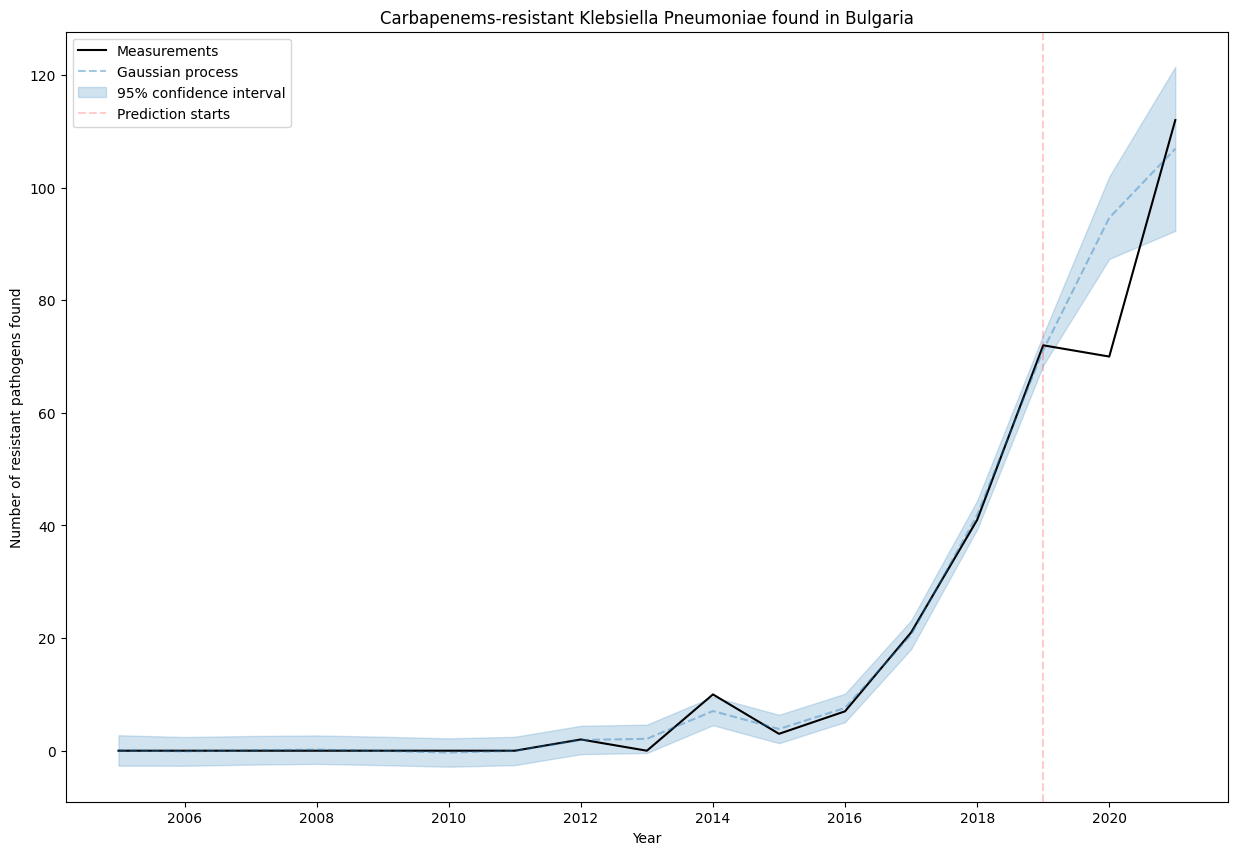

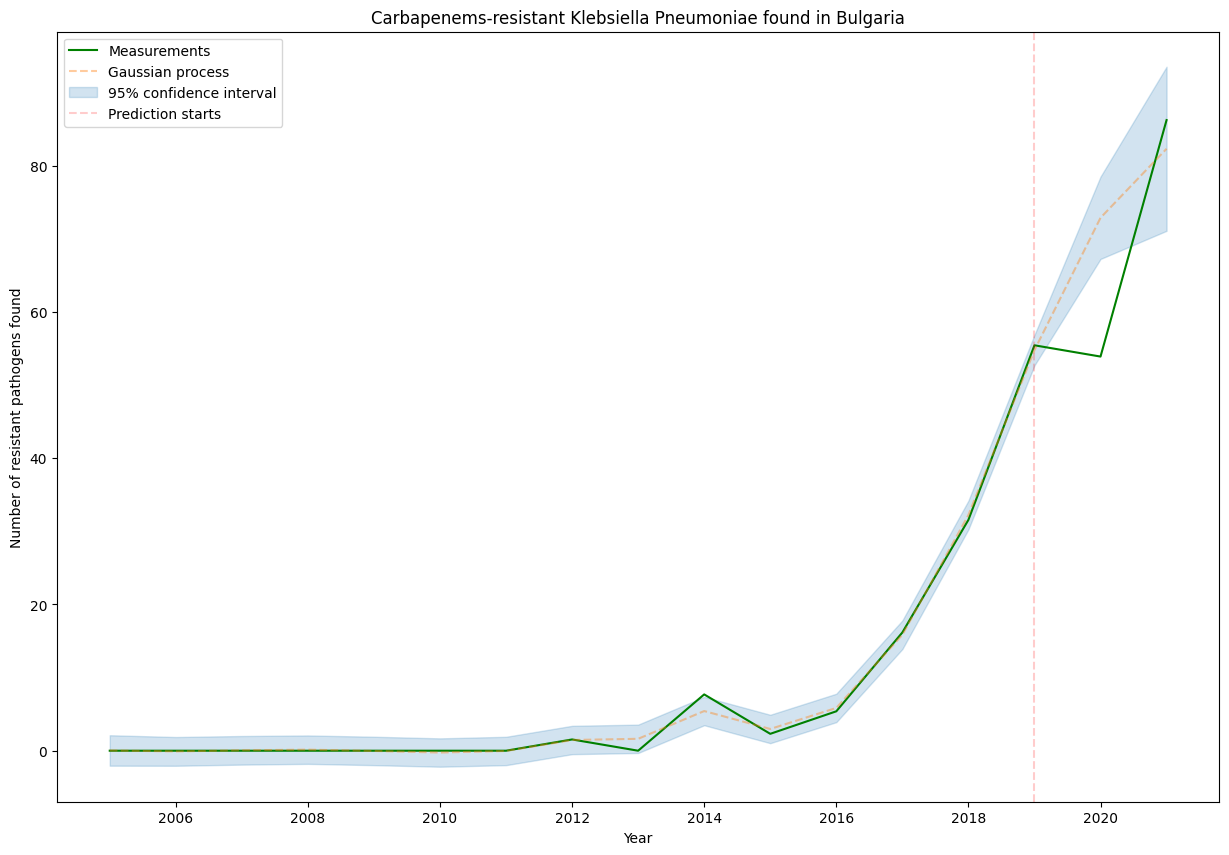

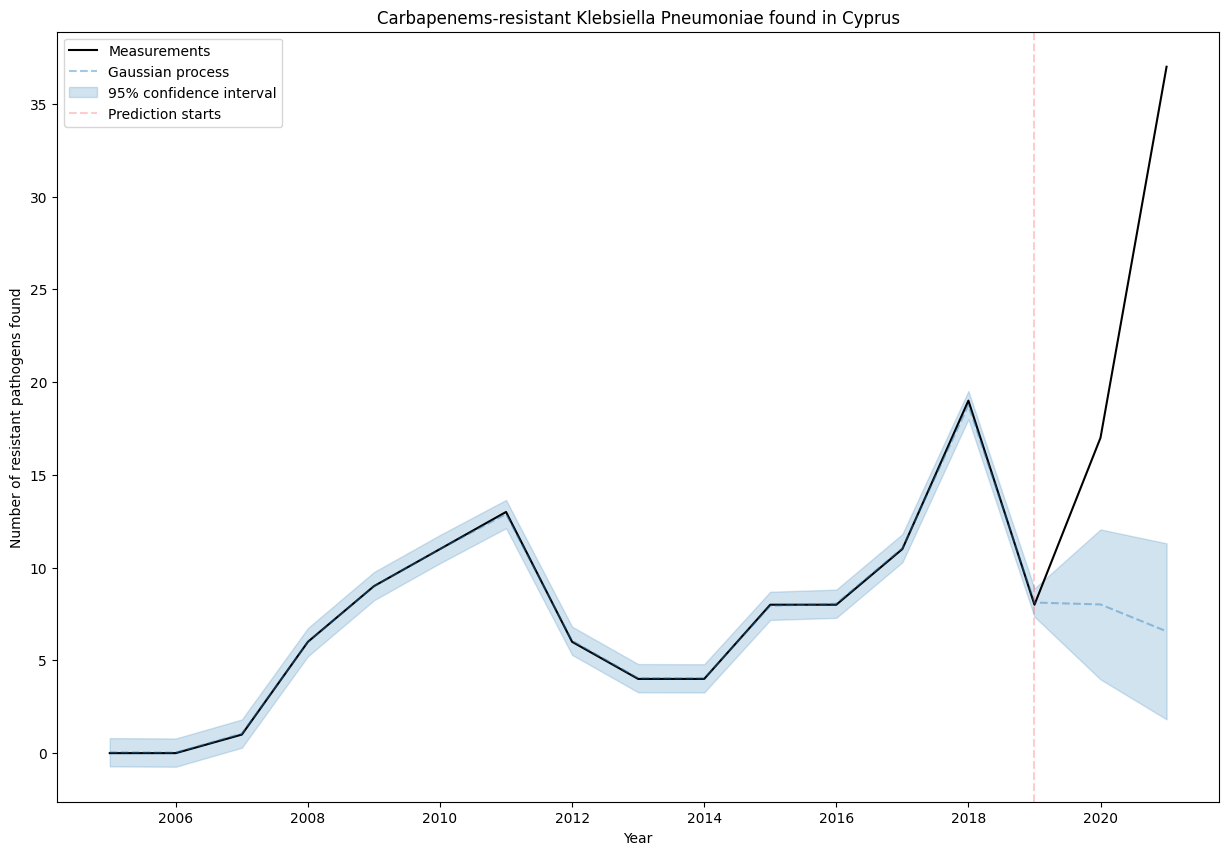

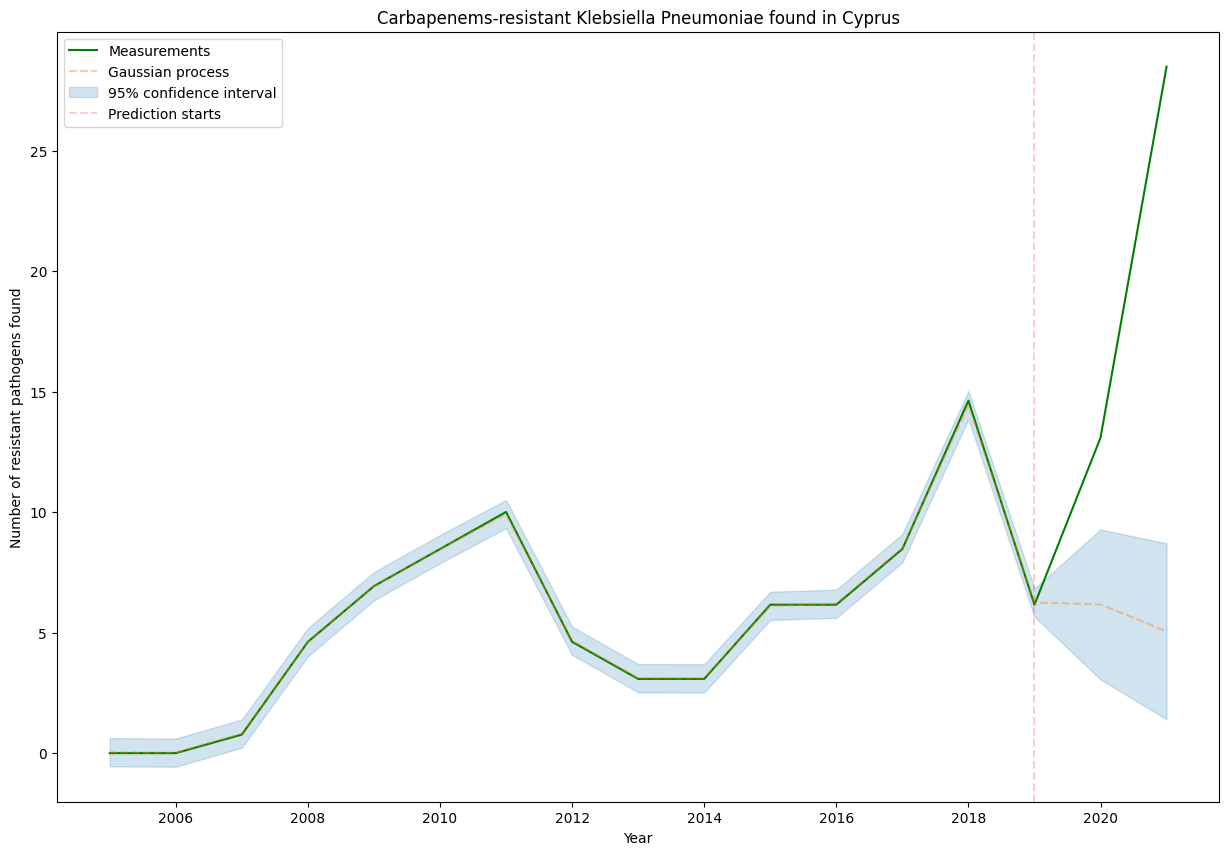

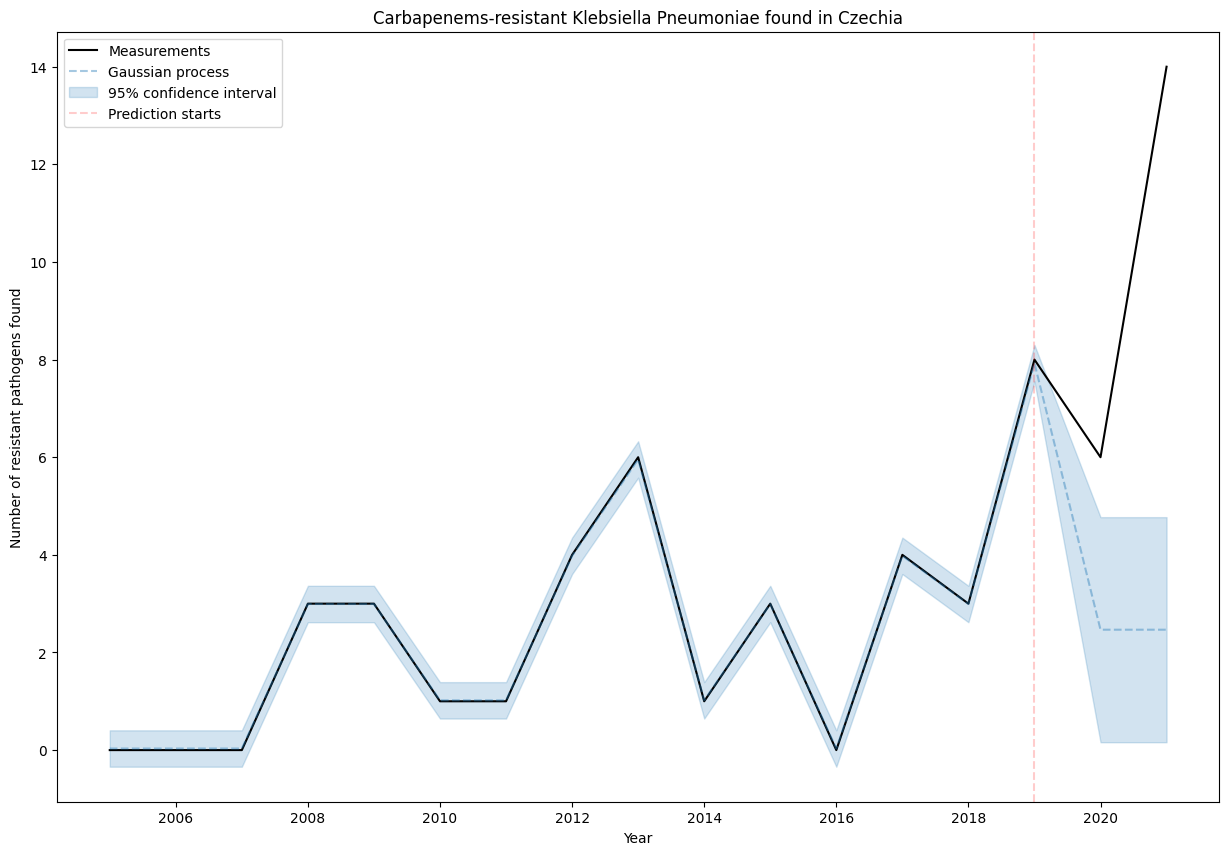

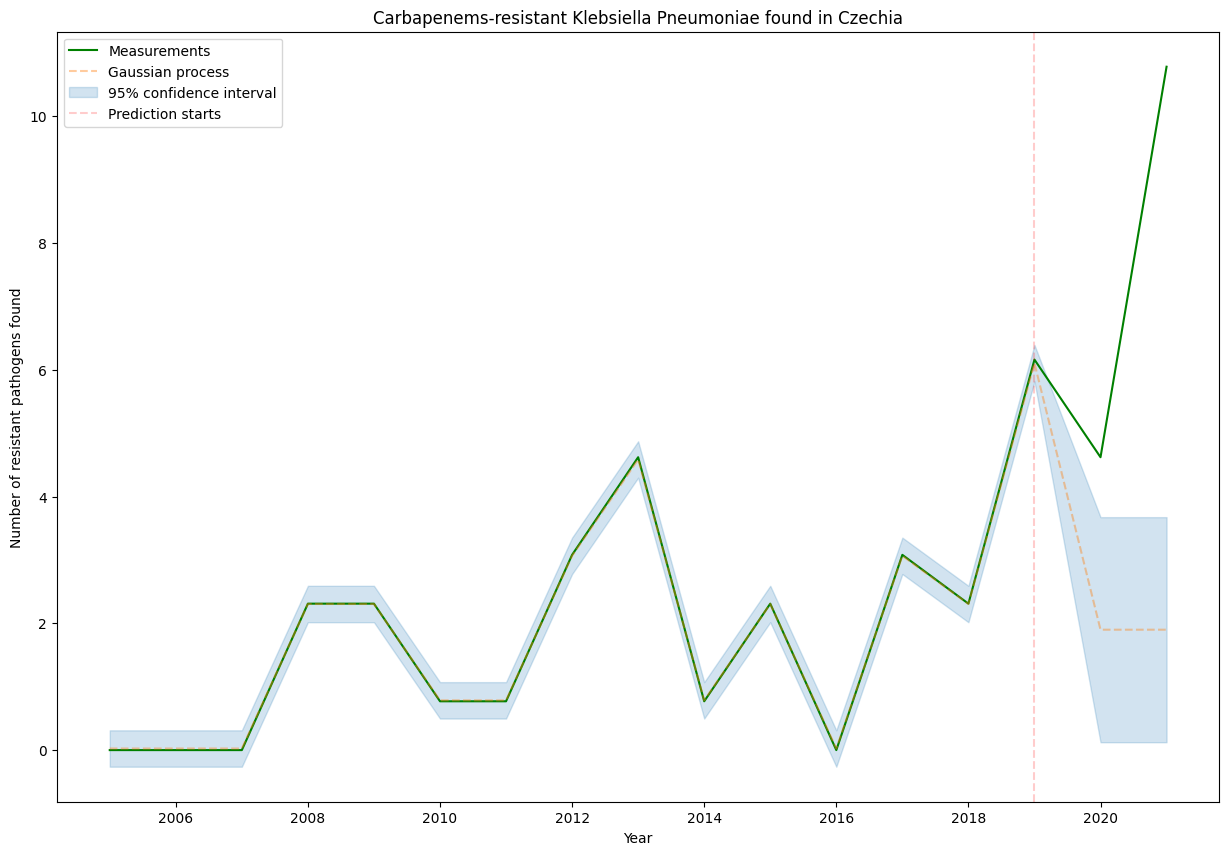

In [58]:
aminoglycosides_indexes= [x for x in range(0,57, 3)]
carbapanems_indexes= [x for x in range(1,57, 3)]
fluoroquinolones_indexes= [x for x in range(2,57, 3)]

for count in range(1,10,3):
    # Define X
    y = np.array(df_names[count]['NumValue'])
    # Define X
    X = np.array(df_names[count]['Time']).reshape(-1,1)
    # 15 years of training and 2 of prediction
    X_train= np.array(df_names[count]['Time'][:15:]).reshape(-1,1)
    X_test = np.array(df_names[count]['Time'][::]).reshape(-1,1)
    y_train= np.array(df_names[count]['NumValue'][:15:])
    y_true = np.array(df_names[count]['NumValue'][::])

    # RBF kernel is set with large lenght-scale parameter to capture long trend
    long_term_trend_kernel = 200.0**2 * RBF(length_scale=50.0)
    # Small irregularities are accounted for in the Rational Quadratic Kernel
    irregularity_kernel = 30 **2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
    # Noise in the dataset is accounted for in the with the addition of white noise
    noise_kernel = 4**2 * RBF(length_scale=0.1) + WhiteKernel(
        noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
    )
    # Resulting Kernel
    resistance_kernel = noise_kernel + long_term_trend_kernel + irregularity_kernel
    # Fit Gaussian Process
    gaussian_process = GaussianProcessRegressor(kernel=resistance_kernel, normalize_y=True)
    gaussian_process.fit(X_train, y_train)
    # Create the predictions with calculations for the std and mean as well
    mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
    # Plot the predictions and data
    plt.figure(figsize=(15, 10))
    plt.plot(X, y, color="black", label="Measurements")
    plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process", linestyle="dashed")
    plt.fill_between(
        X_test.ravel(),
        mean_y_pred - std_y_pred,
        mean_y_pred + std_y_pred,
        color="tab:blue",
        alpha=0.2,
        label= '95% confidence interval'
    )
    plt.axvline(x = 2019, color = 'red', label = 'Prediction starts', alpha=0.2, linestyle="dashed")
    plt.xlabel("Year")
    plt.ylabel("Number of resistant pathogens found")
    save = str(np.array(df_names[count]['RegionName'][:1:]))
    _ = plt.title(df_strs[count])
    plt.legend(loc = 'best')
    plt.savefig(f'C:/Users/franc/resistance_capstone/Antibiotics/plots_gaussian_general/gaussian_{save}_{count}.jpg')
    # print(f'{mean_squared_error(y_true, mean_y_pred)}')


    ######################"Intervention"##########################################

    # 23% reduction
    y= np.array([0.77 * x for x in y])
    y_train= np.array([0.77 * x for x in y_train])
    y_true= np.array([0.77 * x for x in y_true])
    gaussian_process.fit(X_train, y_train)

    # Create the predictions with calculations for the std and mean as well
    mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
    # Plot the predictions and data
    plt.figure(figsize=(15, 10))
    plt.plot(X, y, color="green", label="Measurements")
    plt.plot(X_test, mean_y_pred, color="tab:orange", alpha=0.4, label="Gaussian process", linestyle="dashed")
    plt.fill_between(
        X_test.ravel(),
        mean_y_pred - std_y_pred,
        mean_y_pred + std_y_pred,
        color="tab:blue",
        alpha=0.2,
        label= '95% confidence interval'
    )
    plt.axvline(x = 2019, color = 'red', label = 'Prediction starts', alpha=0.2, linestyle="dashed")
    plt.xlabel("Year")
    plt.ylabel("Number of resistant pathogens found")
    save = str(np.array(df_names[count]['RegionName'][:1:]))
    _ = plt.title(df_strs[count])
    plt.legend(loc = 'best')
    plt.savefig(f'C:/Users/franc/resistance_capstone/Antibiotics/plots_intervention/gaussian_intervention_{save}_{count}.jpg')


<center> References </center>

Alexander, K., Brown, S., Lorin, S., Koll, B., Mazo, D., Ehni, J., & Javaid, W. (2019). Significant Reduction of Hospital Onset Carbapenem-Resistant Enterobacteriaceae Utilizing Infection Prevention Strategies: It Takes a Village!. *Open Forum Infectious Diseases*, 6(Suppl 2), S253. https://doi.org/10.1093/ofid/ofz360.595. PMCID: PMC6809711. 

European Centre for Disease Prevention and Control. (2021). Atlas of health maps and graphs. Retrieved from https://atlas.ecdc.europa.eu/public/index.aspx?Dataset=27&HealthTopic=4 

Lowman, W., Etheredge, H. R., Gaylard, P., & Fabian, J. (2022). The novel application and effect of an ultraviolet light decontamination strategy on the healthcare acquisition of carbapenem-resistant Enterobacterales in a hospital setting. Journal of Hospital Infection, 121, 57-64. https://doi.org/10.1016/j.jhin.2021.12.008.

Rock, C., Curless, M. S., Nowakowski, E., Ross, T., Carson, K. A., Trexler, P., Carroll, K., & Maragakis, L. L. (2016). UV-C Light Disinfection of Carbapenem-Resistant Enterobacteriaceae from High-Touch Surfaces in a Patient Room and Bathroom. *Infection Control & Hospital Epidemiology*, 37(8), 996-997. https://doi.org/10.1017/ice.2016.111
